$V(x)=\sum_{t=1}^T R(x(t))$ \
where  $R(x)=-\|x-x_{goal}\|-variance$ \
and $T=15$

Use all datas 

# Create Environment

In [109]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=50

global M
M=10

global T
global target
T=15
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global obs_para
obs_para=6

global beta
beta=[0.95,0.975,1,1.025,1.05]

global num_system
num_system=5


global coeff
coeff=[]
for i in range(N+1):
    coeff.append(0.1**(N-i))
print(coeff)

[1.0000000000000027e-50, 1.0000000000000028e-49, 1.0000000000000027e-48, 1.0000000000000026e-47, 1.0000000000000026e-46, 1.0000000000000025e-45, 1.0000000000000024e-44, 1.0000000000000025e-43, 1.0000000000000023e-42, 1.0000000000000023e-41, 1.0000000000000022e-40, 1.0000000000000022e-39, 1.000000000000002e-38, 1.0000000000000022e-37, 1.000000000000002e-36, 1.0000000000000019e-35, 1.0000000000000019e-34, 1.0000000000000018e-33, 1.0000000000000018e-32, 1.0000000000000016e-31, 1.0000000000000017e-30, 1.0000000000000016e-29, 1.0000000000000015e-28, 1.0000000000000015e-27, 1.0000000000000015e-26, 1.0000000000000014e-25, 1.0000000000000014e-24, 1.0000000000000013e-23, 1.0000000000000012e-22, 1.0000000000000012e-21, 1.0000000000000011e-20, 1.000000000000001e-19, 1.000000000000001e-18, 1.000000000000001e-17, 1.0000000000000008e-16, 1.0000000000000009e-15, 1.0000000000000008e-14, 1.0000000000000007e-13, 1.0000000000000006e-12, 1.0000000000000006e-11, 1.0000000000000006e-10, 1.0000000000000005e-

In [110]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [111]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    var_theta=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
        var_theta+=vecs[i][2]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    var_theta-=mu_theta**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y,var_theta])/num_system
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    return w

def reward(obs):
    return max(7-max(abs(obs[0]-target[0]),abs(obs[1]-target[1]))-10*obs[3]-10*obs[4],0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r

def value_func(funcs,flags,next_state):
    result=[]
    for i in range(6):
        if flags[i]:
            result.append(0)
        else:
            k,_=funcs[i].predict(next_state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.max(result)

# Learning Settings

In [112]:
global lr
lr=0.01
global eps
eps=0.2
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(funcs,flags,state,init=False):
    explo=exploration()
    if init or explo:
        return np.random.randint(6)
    else:
        result=[]
        for i in range(6):
            if flags[i]:
                return i
            else:
                k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
                result.append(k[0])
    result=np.array(result)
    return np.argmax(result)
    
def decide_u_exploitation(funcs,flags,state,init=False):
    result=[]
    for i in range(6):
        if flags[i]:
            print("Err",i)
            return i
        else:
            k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.argmax(result)

history_su=[0 for i in range(6)]
history_r=[0 for i in range(6)]
history_su_next=[0 for i in range(6)]
flags=[True for i in range(6)]

history_rt=[[[] for i in range(6)] for j in range(N+1)]
history_sut=[[[] for i in range(6)] for j in range(N+1)]
flags_t=[[True for i in range(6)] for j in range(N+1)]

# Simulation


In [113]:
num_iter=80

position_result=[]
observation_result=[]
gpr_list=[[0 for i in range(6)] for j in range(N+1)]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(num_system)]
best_u=[]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0] for _ in range(num_system)])
    observation=observe(position)
    u_t=[]
    r_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(num_system)]
    
    
    history_target=[0 for i in range(6)]
    
    
    coeff=[]
    for i in range(N):
        coeff.append((np.random.random()-0.5)/100+0.8**(N-i))
    coeff.append(1)
    #print(coeff)
    
    
    for time in range(N+1):
        if iterr<5:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,obs_para)
                history_su_next[u_k] = observation_new.reshape(-1,obs_para)  
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation)
            #print(candidates_u)
            #u_k, explo = decide_u(observation,np.array(candidates_u))
            
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
            history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
            
            
    #update
    #calculate cumulative r 
    

    '''
    for j in range(6):
        history_target[j]=last_coeff*history_r[u_t[-i]]
        gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[j], history_target[j])
    '''  
         
    #TODO
       
    for i in range(N+1):
        if i==1:
            for j in range(6):
                history_target[j]=coeff[-1]*history_r[j]
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-5).fit(np.array(history_su[j]).reshape(-1,obs_para), history_target[j].reshape(-1,1))
            
        elif i>1:
            for j in range(6):
                history_tar=[]
                for k in range(history_r[j].shape[0]):
                    history_tar.append(coeff[N+1-i]*history_r[j][k]+value_func(gpr_list[-i+1],flags_t[-i+1],history_su_next[j][k]))
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-5).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))
            '''
            r_t[-i]=0.5**(N+1-i)*r_t[-i]+value_func(gpr_list[-i+1],flags_t[-i+1],observation_t[-i+1])
            history_rt[-i][u_t[-i]].append(r_t[-i])
            history_sut[-i][u_t[-i]].append(observation_t[-i])
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_sut[-i][u_t[-i]]).reshape(-1,5), np.array(history_rt[-i][u_t[-i]]).reshape(-1,1))
            if flags_t[-i][u_t[-i]]:
                flags_t[-i][u_t[-i]]=False
            '''
    for j in range(6):
        history_tar=[]
        for k in range(history_r[j].shape[0]):
            history_tar.append(coeff[0]*history_r[j][k]+value_func(gpr_list[1],flags_t[1],history_su_next[j][k]))
        gpr_list[0][j]=GaussianProcessRegressor(alpha=1e-5).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))

            
        
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
        best_u=u_t
    
    #print(history_su.shape)
    #print(u_t)

  1%|█                                                                                  | 1/80 [00:00<00:29,  2.72it/s]

observation = [-2.04548676e+00 -2.21166591e+00  7.06858347e-01  1.37696421e-04
  2.24882556e-05  6.24560904e-04]


  2%|██                                                                                 | 2/80 [00:00<00:29,  2.61it/s]

observation = [ 7.52094517e-02 -3.35665536e+00  1.41371669e+00  1.07019538e-02
  4.86700291e-03  2.49824361e-03]


  4%|███                                                                                | 3/80 [00:01<00:30,  2.49it/s]

observation = [-3.83562025 -1.66975729  2.59181394  0.0115041   0.0091269   0.00839687]


  5%|████▏                                                                              | 4/80 [00:01<00:31,  2.38it/s]

observation = [-1.16265636e-01 -2.40328459e-01 -2.35619449e-01  2.73903139e-03
  1.28354574e-02  6.93956559e-05]


  6%|█████▏                                                                             | 5/80 [00:02<00:32,  2.31it/s]

observation = [-2.64864610e+00 -1.22856044e+00 -2.35619449e-01  1.82667340e-03
  1.78644005e-03  6.93956559e-05]


  8%|██████▏                                                                            | 6/80 [00:02<00:35,  2.10it/s]

observation = [ 1.44174099e-01  9.55732334e-01 -2.35619449e-01  1.18359378e-03
  2.67250072e-02  6.93956559e-05]


  9%|███████▎                                                                           | 7/80 [00:03<00:37,  1.93it/s]

observation = [-1.20278160e+00 -3.29163193e+00  4.85722573e-17  2.88664484e-04
  5.71214721e-03  5.83556773e-33]


 10%|████████▎                                                                          | 8/80 [00:03<00:39,  1.84it/s]

observation = [-0.43648044 -0.30981051  2.74889357  0.03821983  0.01639707  0.01561402]


 11%|█████████▎                                                                         | 9/80 [00:04<00:40,  1.74it/s]

observation = [ 2.62677644e-01 -1.52493767e-01  6.93889390e-18  2.59461798e-03
  1.48536374e-02  1.82963345e-33]


 12%|██████████▎                                                                       | 10/80 [00:05<00:42,  1.64it/s]

observation = [ 1.69724579e-01 -1.34495586e+00 -2.35619449e-01  6.61295784e-03
  1.96711307e-03  6.93956559e-05]


 14%|███████████▎                                                                      | 11/80 [00:05<00:45,  1.53it/s]

observation = [-7.47229269e-01 -2.07302836e+00 -7.06858347e-01  1.02174859e-03
  3.25533435e-05  6.24560904e-04]


 15%|████████████▎                                                                     | 12/80 [00:06<00:46,  1.45it/s]

observation = [ 1.30018345e+00 -6.73126385e+00  1.41371669e+00  6.14866477e-02
  5.25467048e-02  2.49824361e-03]


 16%|█████████████▎                                                                    | 13/80 [00:07<00:48,  1.38it/s]

observation = [3.71205098e+00 2.00910478e+00 7.06858347e-01 1.51760525e-02
 6.35466472e-02 6.24560904e-04]


 18%|██████████████▎                                                                   | 14/80 [00:08<00:50,  1.30it/s]

observation = [3.17743628e+00 9.68991391e-01 7.06858347e-01 1.14541030e-02
 3.73457264e-02 6.24560904e-04]


 19%|███████████████▍                                                                  | 15/80 [00:09<00:52,  1.23it/s]

observation = [-1.24211208e+00 -2.36670091e+00 -4.71238898e-01  3.05958594e-04
  5.27082867e-04  2.77582624e-04]


 20%|████████████████▍                                                                 | 16/80 [00:10<00:54,  1.17it/s]

observation = [1.21110640e+00 1.01602659e+00 4.71238898e-01 4.12673693e-05
 2.71599492e-02 2.77582624e-04]


 21%|█████████████████▍                                                                | 17/80 [00:11<00:57,  1.10it/s]

observation = [2.80243636e+00 1.82372314e+00 7.06858347e-01 1.15655155e-03
 5.25259901e-02 6.24560904e-04]


 22%|██████████████████▍                                                               | 18/80 [00:12<00:59,  1.04it/s]

observation = [-4.19015971e+00 -5.94204675e+00 -2.35619449e+00  1.36098048e-01
  2.90226919e-03  6.93956559e-03]


 24%|███████████████████▍                                                              | 19/80 [00:13<01:01,  1.01s/it]

observation = [ 0.42817043 -0.47017875 -1.41371669  0.0043971   0.00966688  0.00249824]


 25%|████████████████████▌                                                             | 20/80 [00:14<01:04,  1.07s/it]

observation = [0.65796989 3.34193545 1.88495559 0.0280967  0.04260724 0.00444132]


 26%|█████████████████████▌                                                            | 21/80 [00:15<01:06,  1.13s/it]

observation = [7.21370813e-01 7.76481838e-02 2.12057504e+00 1.01448494e-05
 7.58357019e-03 5.62104813e-03]


 28%|██████████████████████▌                                                           | 22/80 [00:17<01:09,  1.19s/it]

observation = [2.90474099e+00 1.24862137e+00 7.06858347e-01 6.82143880e-03
 4.01993260e-02 6.24560904e-04]


 29%|███████████████████████▌                                                          | 23/80 [00:18<01:11,  1.25s/it]

observation = [-3.88374294 -3.50016655 -2.98451302  0.00423754  0.02077512  0.01360155]


 30%|████████████████████████▌                                                         | 24/80 [00:20<01:13,  1.31s/it]

observation = [ 0.58967212 -0.58730004  3.06305284  0.00537676  0.00836021  0.01172787]


 31%|█████████████████████████▋                                                        | 25/80 [00:21<01:15,  1.37s/it]

observation = [1.91814810e+00 6.89656462e-01 9.42477796e-01 3.80241831e-03
 2.72136803e-02 1.11033050e-03]


 32%|██████████████████████████▋                                                       | 26/80 [00:23<01:17,  1.44s/it]

observation = [-2.59052227e+00 -7.49088598e+00 -1.64933614e+00  1.00314840e-01
  3.12287689e-02  3.40038714e-03]


 34%|███████████████████████████▋                                                      | 27/80 [00:24<01:20,  1.51s/it]

observation = [-1.04489922e+00  1.43685751e+00  2.59181394e+00  3.06234573e-02
  1.31316137e-04  8.39687437e-03]


 35%|████████████████████████████▋                                                     | 28/80 [00:26<01:23,  1.61s/it]

observation = [2.04691697e+00 7.79379421e-01 9.42477796e-01 1.57190931e-03
 2.39249060e-02 1.11033050e-03]


 36%|█████████████████████████████▋                                                    | 29/80 [00:28<01:26,  1.70s/it]

observation = [3.08465458e+00 1.65538079e+00 2.35619449e-01 4.00026224e-03
 4.73079711e-02 6.93956559e-05]


 38%|██████████████████████████████▊                                                   | 30/80 [00:30<01:29,  1.79s/it]

observation = [-1.04954002e+00 -2.07901633e+00  1.88495559e+00  5.53287523e-04
  1.46170770e-03  4.44132198e-03]


 39%|███████████████████████████████▊                                                  | 31/80 [00:32<01:32,  1.88s/it]

observation = [-2.39848694  1.73389044  3.06305284  0.03161346  0.0130349   0.01172787]


 40%|████████████████████████████████▊                                                 | 32/80 [00:35<01:35,  1.99s/it]

observation = [ 4.10460223e+00  1.39596135e+00 -1.80411242e-17  1.55050220e-02
  4.48942500e-02  5.09601063e-33]


 41%|█████████████████████████████████▊                                                | 33/80 [00:37<01:37,  2.08s/it]

observation = [ 0.4470614  -0.40245049  1.33517688  0.05996573  0.00219518  0.03060348]


 42%|██████████████████████████████████▊                                               | 34/80 [00:39<01:39,  2.17s/it]

observation = [-9.61213022e+00 -7.34445636e-01 -2.59181394e+00  5.81800215e-02
  3.88524849e-01  8.39687437e-03]


 44%|███████████████████████████████████▉                                              | 35/80 [00:42<01:41,  2.26s/it]

observation = [ 3.55740582e+00  6.40483296e-01 -7.06858347e-01  1.19282995e-02
  2.57681192e-02  6.24560904e-04]


 45%|████████████████████████████████████▉                                             | 36/80 [00:44<01:44,  2.38s/it]

observation = [5.74371961e+00 2.77218384e+00 4.71238898e-01 1.98360585e-02
 8.10297682e-02 2.77582624e-04]


 46%|█████████████████████████████████████▉                                            | 37/80 [00:47<01:48,  2.52s/it]

observation = [ 2.26599245e+00  8.84702778e-01 -1.80411242e-17  3.56308690e-03
  2.89431877e-02  5.09601063e-33]


 48%|██████████████████████████████████████▉                                           | 38/80 [00:50<01:51,  2.64s/it]

observation = [ 1.43656066e+00 -9.27469861e-02 -7.06858347e-01  2.97048380e-03
  1.17376284e-02  6.24560904e-04]


 49%|███████████████████████████████████████▉                                          | 39/80 [00:53<01:53,  2.76s/it]

observation = [2.82808322e+00 3.56439993e+00 1.17809725e+00 1.26591422e-03
 9.61462911e-02 1.73489140e-03]


 50%|█████████████████████████████████████████                                         | 40/80 [00:56<01:56,  2.90s/it]

observation = [-6.92036464e-01 -6.95483368e+00  1.17809725e+00  4.69760953e-02
  3.20713061e-02  1.73489140e-03]


 51%|██████████████████████████████████████████                                        | 41/80 [01:00<01:59,  3.07s/it]

observation = [ 3.23673351e-01 -1.78777515e-01  7.06858347e-01  4.91432922e-04
  9.89934896e-03  6.24560904e-04]


 52%|███████████████████████████████████████████                                       | 42/80 [01:03<02:02,  3.23s/it]

observation = [4.34670569e+00 4.12952510e+00 9.42477796e-01 1.14287172e-03
 1.35750721e-01 1.11033050e-03]


 54%|████████████████████████████████████████████                                      | 43/80 [01:07<02:05,  3.39s/it]

observation = [2.86030102e+00 3.04676913e+00 1.41371669e+00 5.25692462e-05
 8.66387261e-02 2.49824361e-03]


 55%|█████████████████████████████████████████████                                     | 44/80 [01:11<02:07,  3.55s/it]

observation = [2.54284473e+00 2.92218330e+00 1.41371669e+00 6.53970119e-04
 7.40550421e-02 2.49824361e-03]


 56%|██████████████████████████████████████████████▏                                   | 45/80 [01:15<02:09,  3.71s/it]

observation = [2.75756869e+00 9.37234863e-01 2.35619449e-01 5.30060260e-03
 2.82988334e-02 6.93956559e-05]


 57%|███████████████████████████████████████████████▏                                  | 46/80 [01:20<02:12,  3.90s/it]

observation = [ 1.53875129e+00 -8.59182122e-01 -9.42477796e-01  3.95273211e-03
  4.33945231e-03  1.11033050e-03]


 59%|████████████████████████████████████████████████▏                                 | 47/80 [01:24<02:13,  4.05s/it]

observation = [-1.80099312e+00  2.04681626e+00  2.59181394e+00  5.01138778e-02
  2.63511811e-04  8.39687437e-03]


 60%|█████████████████████████████████████████████████▏                                | 48/80 [01:29<02:15,  4.22s/it]

observation = [ 3.16250069e+00  1.72429697e+00 -1.80411242e-17  4.97008745e-03
  5.07401968e-02  5.09601063e-33]


 61%|██████████████████████████████████████████████████▏                               | 49/80 [01:33<02:16,  4.39s/it]

observation = [ 0.39028073 -1.61520098 -2.74889357  0.0033578   0.0232061   0.01561402]


 62%|███████████████████████████████████████████████████▎                              | 50/80 [01:38<02:17,  4.58s/it]

observation = [-8.17650164e-01 -1.79199228e+00 -1.64933614e+00  3.27400078e-03
  1.67881503e-05  3.40038714e-03]


 64%|████████████████████████████████████████████████████▎                             | 51/80 [01:43<02:17,  4.74s/it]

observation = [-3.19459919e-01 -1.00145838e+00  2.82743339e+00  7.22173390e-05
  6.21594271e-05  9.99297446e-03]


 65%|█████████████████████████████████████████████████████▎                            | 52/80 [01:49<02:17,  4.90s/it]

observation = [2.13510325e+00 3.17087243e-01 9.42477796e-01 6.85368615e-03
 2.08352240e-02 1.11033050e-03]


 66%|██████████████████████████████████████████████████████▎                           | 53/80 [01:54<02:17,  5.10s/it]

observation = [ 1.68974717e-02 -1.18742394e+00  3.06305284e+00  1.01708344e-03
  5.63946522e-03  1.17278659e-02]


 68%|███████████████████████████████████████████████████████▎                          | 54/80 [02:00<02:17,  5.29s/it]

observation = [-6.28606294 -3.56689359 -2.82743339  0.05834595  0.04592274  0.00999297]


 69%|████████████████████████████████████████████████████████▍                         | 55/80 [02:06<02:17,  5.51s/it]

observation = [2.88454761e+00 1.39087387e+00 2.35619449e-01 6.59356630e-03
 4.38436877e-02 6.93956559e-05]


 70%|█████████████████████████████████████████████████████████▍                        | 56/80 [02:12<02:17,  5.72s/it]

observation = [2.93936254e+00 1.89877193e+00 7.06858347e-01 2.07203065e-03
 5.80255020e-02 6.24560904e-04]


 71%|██████████████████████████████████████████████████████████▍                       | 57/80 [02:19<02:16,  5.92s/it]

observation = [ 2.85143234e+00  1.22606877e+00 -7.06858347e-01  6.33922081e-03
  3.67558045e-02  6.24560904e-04]


 72%|███████████████████████████████████████████████████████████▍                      | 58/80 [02:25<02:15,  6.18s/it]

observation = [ 1.20883826e-01 -1.51766991e+00 -2.59181394e+00  1.39902058e-02
  4.62437710e-04  8.39687437e-03]


 74%|████████████████████████████████████████████████████████████▍                     | 59/80 [02:32<02:14,  6.42s/it]

observation = [-2.29731796 -3.66364553 -2.27765467  0.01199194  0.05455302  0.02005534]


 75%|█████████████████████████████████████████████████████████████▌                    | 60/80 [02:40<02:12,  6.64s/it]

observation = [ 6.03406356e+00 -2.12067997e+00  9.42477796e-01  2.58868377e-02
  1.14527742e-04  1.11033050e-03]


 76%|██████████████████████████████████████████████████████████████▌                   | 61/80 [02:47<02:12,  6.98s/it]

observation = [1.86652744 2.81002818 1.88495559 0.00482292 0.05004146 0.00444132]


 78%|███████████████████████████████████████████████████████████████▌                  | 62/80 [02:55<02:10,  7.23s/it]

observation = [-1.79379503e+00 -5.92391896e+00  1.17809725e+00  3.23459806e-02
  3.60659625e-02  1.73489140e-03]


 79%|████████████████████████████████████████████████████████████████▌                 | 63/80 [03:03<02:06,  7.45s/it]

observation = [2.66620211e+00 1.18142797e+00 9.42477796e-01 4.00576963e-03
 3.38415274e-02 1.11033050e-03]


 80%|█████████████████████████████████████████████████████████████████▌                | 64/80 [03:12<02:07,  7.99s/it]

observation = [ 3.05464509e+00  1.17985290e+00 -1.80411242e-17  3.92385172e-03
  3.18241035e-02  5.09601063e-33]


 81%|██████████████████████████████████████████████████████████████████▋               | 65/80 [03:21<02:02,  8.16s/it]

observation = [ 1.40616018e+00 -3.58092608e-02  2.35619449e-01  2.64040005e-03
  1.26332038e-02  6.93956559e-05]


 82%|███████████████████████████████████████████████████████████████████▋              | 66/80 [03:30<01:56,  8.33s/it]

observation = [ 1.27212265e+00  1.84936804e-02 -1.80411242e-17  1.68488258e-03
  1.19604834e-02  5.09601063e-33]


 84%|████████████████████████████████████████████████████████████████████▋             | 67/80 [03:39<01:50,  8.53s/it]

observation = [ 5.12831308e+00  2.29550087e+00 -7.06858347e-01  1.20656362e-02
  6.81261541e-02  6.24560904e-04]


 85%|█████████████████████████████████████████████████████████████████████▋            | 68/80 [03:48<01:45,  8.78s/it]

observation = [1.74416499e+00 6.31152843e-01 4.71238898e-01 2.09145341e-03
 2.40251930e-02 2.77582624e-04]


 86%|██████████████████████████████████████████████████████████████████████▋           | 69/80 [03:58<01:39,  9.01s/it]

observation = [2.66003624e+00 1.38215025e+00 2.35619449e-01 3.50629653e-03
 4.10270225e-02 6.93956559e-05]


 88%|███████████████████████████████████████████████████████████████████████▊          | 70/80 [04:08<01:32,  9.29s/it]

observation = [1.27604076e+00 8.79183740e-01 1.41371669e+00 3.80071975e-05
 2.34004022e-02 2.49824361e-03]


 89%|████████████████████████████████████████████████████████████████████████▊         | 71/80 [04:18<01:25,  9.53s/it]

observation = [ 4.44456523e-01 -6.52933065e-01  3.06305284e+00  1.06418225e-03
  1.04976294e-02  1.17278659e-02]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 72/80 [04:28<01:18,  9.75s/it]

observation = [ 4.06979798e+00  1.98914812e+00 -1.17809725e+00  7.64057923e-03
  5.21602343e-02  1.73489140e-03]


 91%|██████████████████████████████████████████████████████████████████████████▊       | 73/80 [04:39<01:10, 10.04s/it]

observation = [2.53047783e+00 1.55170764e+00 1.64933614e+00 2.04404614e-03
 4.54313147e-02 3.40038714e-03]


 92%|███████████████████████████████████████████████████████████████████████████▊      | 74/80 [04:50<01:01, 10.32s/it]

observation = [ 1.51240916e+00  3.07449058e-01 -4.71238898e-01  3.60432745e-03
  2.00985662e-02  2.77582624e-04]


 94%|████████████████████████████████████████████████████████████████████████████▉     | 75/80 [05:01<00:52, 10.60s/it]

observation = [ 0.27849924 -0.74537094 -0.86393798  0.0268487   0.05545643  0.0367103 ]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 76/80 [05:13<00:43, 10.99s/it]

observation = [ 3.02697232e+00  1.92171951e+00 -7.06858347e-01  3.25129947e-03
  5.52710530e-02  6.24560904e-04]


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 77/80 [05:25<00:34, 11.40s/it]

observation = [1.66197469e+00 8.34913100e-01 7.06858347e-01 1.33647100e-03
 2.84646508e-02 6.24560904e-04]


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 78/80 [05:37<00:23, 11.64s/it]

observation = [2.55499889e+00 2.95791738e+00 2.12057504e+00 5.56125327e-04
 7.61125467e-02 5.62104813e-03]


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 79/80 [05:50<00:11, 11.97s/it]

observation = [1.30042644 2.2597822  2.59181394 0.00342782 0.02968327 0.00839687]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [06:03<00:00,  4.54s/it]

observation = [1.90497050e+00 7.46977371e-01 7.06858347e-01 3.80730618e-03
 2.78494972e-02 6.24560904e-04]


# Results

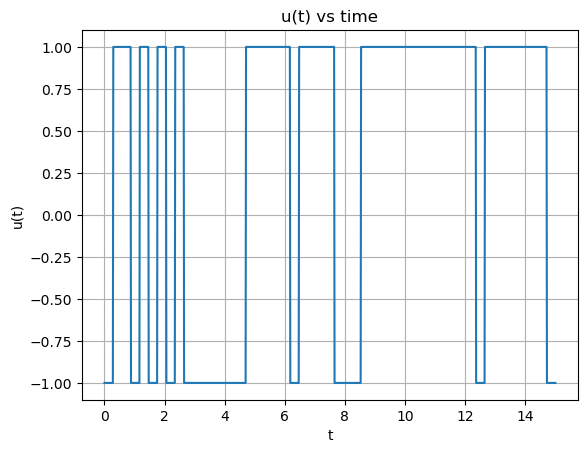

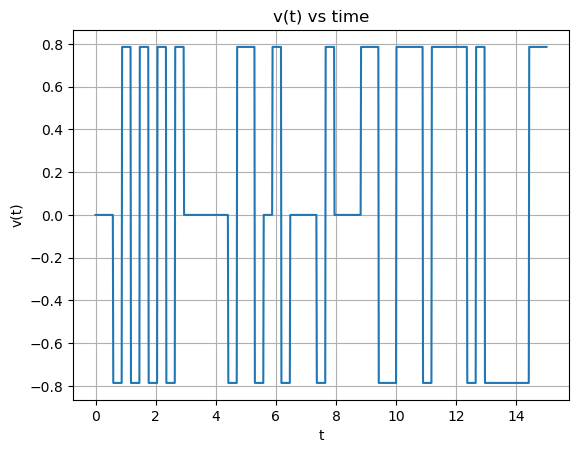

In [114]:
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
        
x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


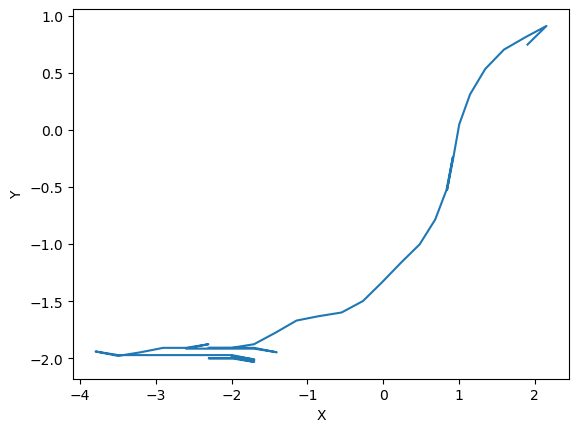

In [115]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

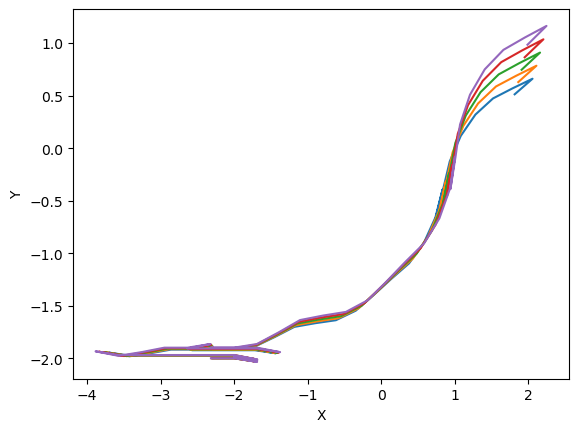

8.326584199958427


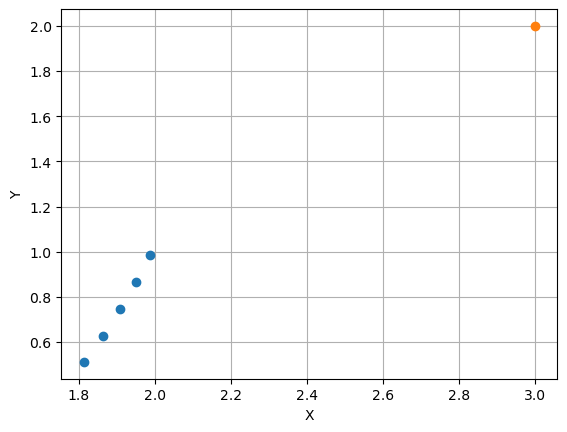

In [116]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()


## Best Trajectory

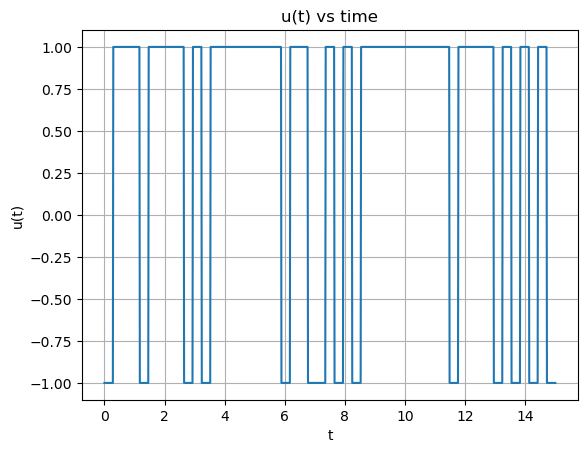

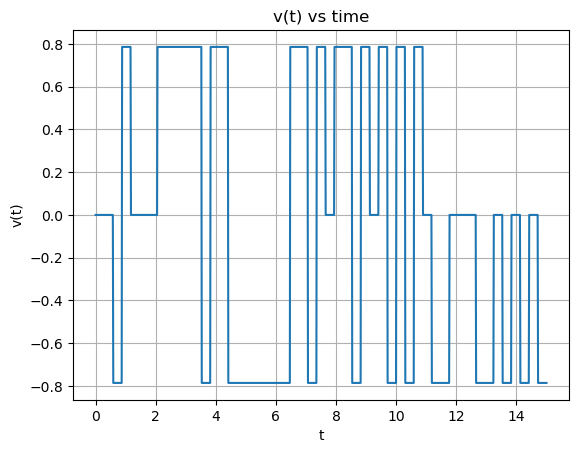

In [117]:
us=[2*(0.5-i%2) for i in best_u]
vs=[(1-i//2)*np.pi/4 for i in best_u]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

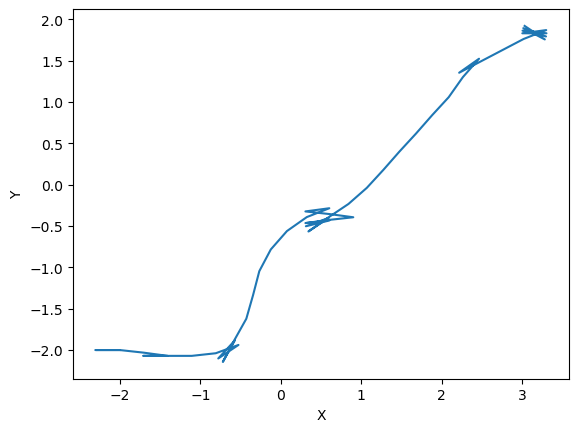

In [118]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

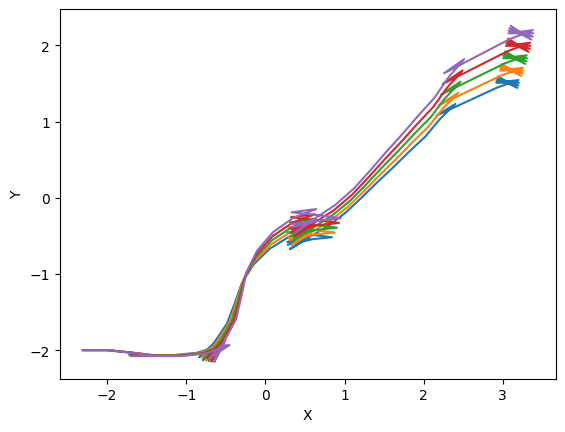

1.1320959790804956


In [119]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

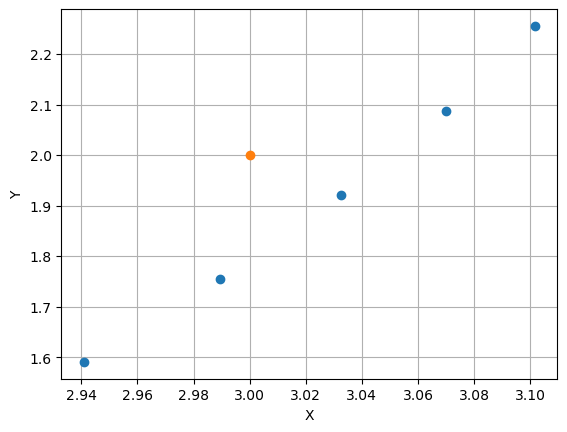

In [120]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    #plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

## Pure Exploitation Trajectory

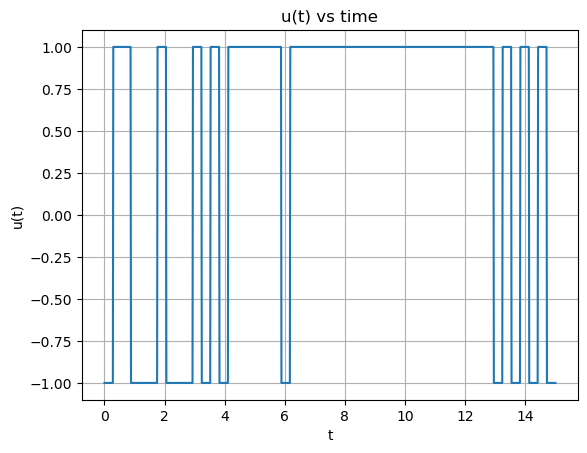

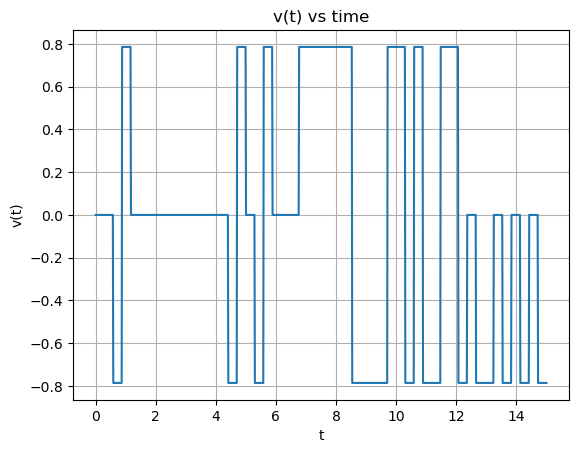

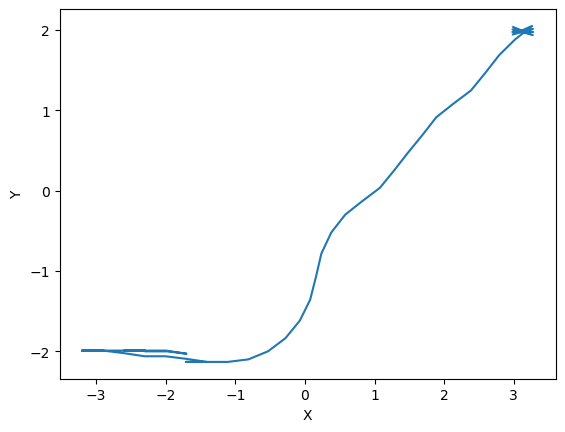

In [121]:
position=np.array([[-2,-2,0] for _ in range(num_system)])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(num_system)]

for time in range(N+1):           
    
    #print(candidates_u)
    u_k = decide_u_exploitation(gpr_list[time],flags,observation)
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
    

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

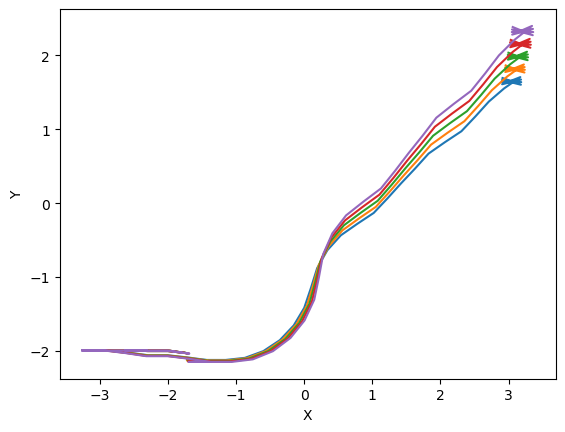

1.0943401572114007


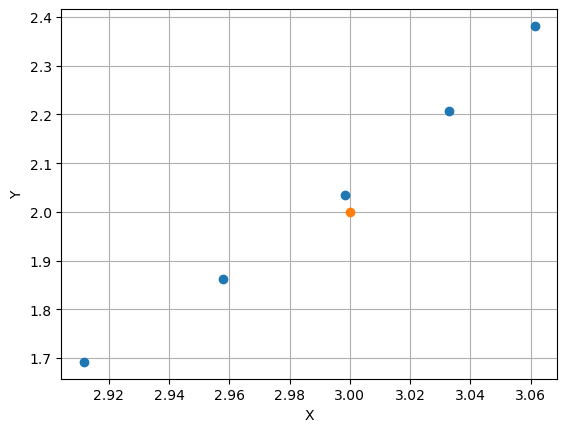

In [122]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(position))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()